In [3]:
# Data Set: FD002

# Train trjectories: 260

# Test trajectories: 259

# Conditions: SIX

# Fault Modes: ONE (HPC Degradation)

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
pwd()

'/Users/Shikhar/Desktop/Downloads/CMaps'

In [6]:
dir_path = '/Users/Shikhar/Desktop/Downloads/CMaps/'
train_file = 'train_FD002.txt'
test_file = 'test_FD002.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD002.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

print(train.shape)
train.head()

(53759, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [7]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,148
1,1,2,147
2,1,3,146
3,1,4,145
4,1,5,144


In [8]:
## EDA

In [9]:
settings_df = train[setting_names].copy()
settings_df['setting_1'] = settings_df['setting_1'].round()
settings_df['setting_2'] = settings_df['setting_2'].round(decimals=2)
settings_df.groupby(by=setting_names).size()

setting_1  setting_2  setting_3
0.0        0.00       100.0         8044
10.0       0.25       100.0         8096
20.0       0.70       100.0         8122
25.0       0.62       60.0          8002
35.0       0.84       100.0         8037
42.0       0.84       100.0        13458
dtype: int64

In [10]:
#Plotting
# Previously I’ve plotted all sensor signals of multiple engines. Unfortunately, the current signals are rather incomprehensible. To get a clearer understanding of what’s going on I chose to plot just one sensor of one unit.

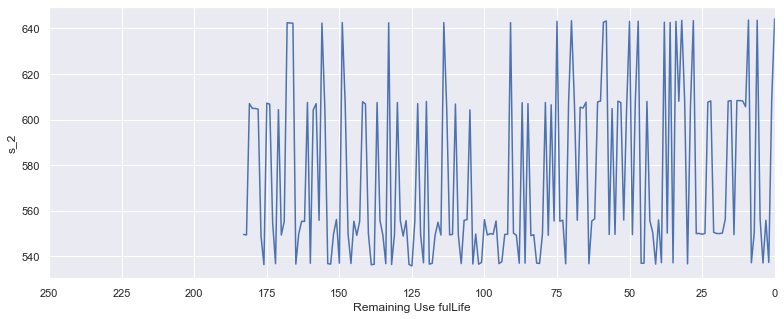

In [11]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

# specifically plotting s_2, I'm using this as an example throughout the rest of the analysis  
plot_signal(train, 's_2', unit_nr=10)

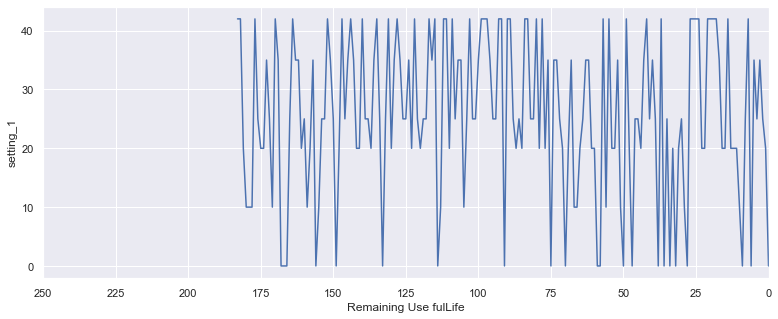

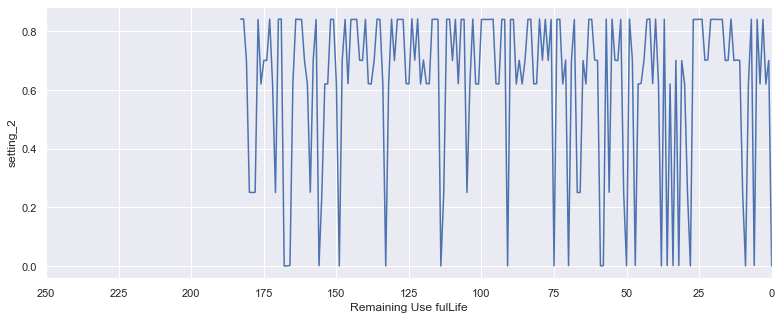

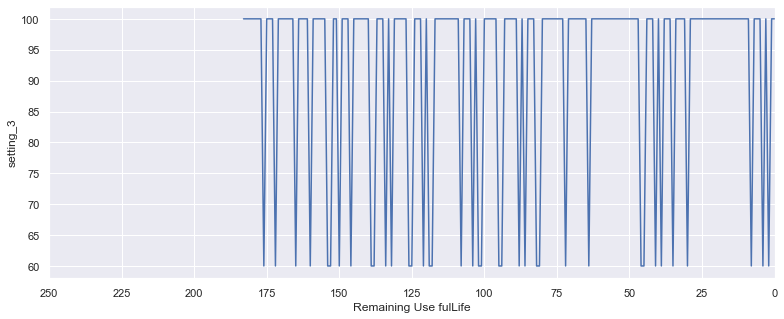

In [12]:
for setting in setting_names:
    plot_signal(train, setting, unit_nr=10)

In [13]:
## Baseline model

In [14]:
#The baseline model will be a simple linear regression without any feature engineering or selection.

In [15]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy()

In [16]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [17]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.941923409968922, R2:0.7226666213449335
test set RMSE:32.64244063055652, R2:0.6315800619889291


In [21]:
#RF
from sklearn.model_selection import RandomizedSearchCV


In [25]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

#Random Forest Regressor param_dict
n_estimators = [10,20,30,50]
max_depth = [6,8,10,12]
min_samples_split = [60,70,80,100]
min_samples_leaf = [30,40,50,60]
# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
# Create an instance of the random forest regressor
rf_model = RandomForestRegressor()

#RandomSearch
rf_random = RandomizedSearchCV(rf_model,param_dict,verbose=0,cv=5)
rf_random.fit(X_train,y_train_clipped)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [6, 8, 10, 12],
                                        'min_samples_leaf': [30, 40, 50, 60],
                                        'min_samples_split': [60, 70, 80, 100],
                                        'n_estimators': [10, 20, 30, 50]})

In [26]:
## Final model

print(rf_random.best_params_)
print(rf_random.best_score_)

# best try

{'n_estimators': 20, 'min_samples_split': 70, 'min_samples_leaf': 40, 'max_depth': 12}
0.7506549292674023


In [31]:
rf = RandomForestRegressor(n_estimators=20,max_features="sqrt", random_state=42,
                           min_samples_leaf=40, min_samples_split=70, 
                           max_depth=12)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:19.345109651270647, R2:0.7844266134094977
test set RMSE:29.967511585074156, R2:0.6894873889644854


In [19]:
from xgboost import XGBRegressor
# Scaling
from sklearn.preprocessing import MinMaxScaler

In [22]:
# Number of trees
n_estimators = [70,75,80,85,90]

# Maximum depth of trees
max_depth = [6,8,9,10]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [20,30,40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}#
#Scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an instance of the XGBoost
xgb_model = XGBRegressor(learning_rate=0.1)

#RandomSearch
xgb_random = RandomizedSearchCV(xgb_model,param_dict,verbose=2,cv=5)


xgb_random.fit(X_train_scaled,y_train_clipped)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[14:54:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=10, min_samples_leaf=40, min_samples_split=50, n_estimators=70; total time=  13.0s
[14:54:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some 

[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=150, n_estimators=70; total time=  14.9s
[14:57:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   9.6s
[14:57:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[CV] END max_depth=10, min_samples_leaf=40, min_samples_split=150, n_estimators=70; total time=  12.8s
[14:59:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=90; total time=  14.5s
[14:59:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistake

[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=85; total time=   8.6s
[15:02:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=9, min_samples_leaf=40, min_samples_split=50, n_estimators=70; total time=  11.3s
[15:02:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistaken

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          ma...
                                          max_leaves=None,
                                          min_c

In [23]:
## Final model

print(xgb_random.best_params_)
print(xgb_random.best_score_)

# best try

{'n_estimators': 70, 'min_samples_split': 50, 'min_samples_leaf': 40, 'max_depth': 9}
0.7713389950410695


In [24]:
xgb = XGBRegressor(n_estimators=70,max_features="sqrt", random_state=42,
                           min_samples_leaf=40, min_samples_split=50, 
                           max_depth=9)
xgb.fit(X_train_scaled, y_train_clipped)

# predict and evaluate
y_hat_train = xgb.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = xgb.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

[15:04:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


train set RMSE:13.086384383340453, R2:0.9013511338020288
test set RMSE:29.261383486398188, R2:0.7039482783377473
